In [1]:
from scipy.io import arff
import pandas as pd
import numpy as np




*   play with net - leaky Relu, activation function, batchnorm
*   PCA - visualization
*   Generate 100 samples



# Preprocess Data

In [2]:
df = pd.read_csv('cellular_traffic.csv')

In [3]:
df.head()

,bs,time_hour,users,packets,bytes
0,1,1345305600,1,3,3473.0
1,2,1345305600,1,12,2496.0
2,3,1345305600,1,18,5616.0
3,4,1345305600,1,113,156068.0
4,5,1345305600,1,19,5928.0


In [4]:
df.describe()

,bs,time_hour,users,packets,bytes
count,1.625680e+06,1.625680e+06,1.625680e+06,1.625680e+06,1.625680e+06
mean,5.372162e+03,1.345643e+09,1.377170e+01,1.724474e+03,8.223766e+06
std,3.060182e+03,1.952034e+05,2.034654e+01,4.600335e+03,1.902086e+08
min,1.000000e+00,1.345306e+09,1.000000e+00,0.000000e+00,0.000000e+00
25%,2.938000e+03,1.345475e+09,2.000000e+00,7.200000e+01,8.074000e+04
50%,5.276000e+03,1.345637e+09,6.000000e+00,4.430000e+02,5.738290e+05
75%,7.528000e+03,1.345806e+09,1.600000e+01,1.695000e+03,2.553905e+06
max,1.326900e+04,1.345993e+09,4.130000e+02,7.945850e+05,1.148665e+11


In [5]:
df.isnull().sum()

bs           0
time_hour    0
users        0
packets      0
bytes        0
dtype: int64

In [6]:
df.select_dtypes(include=np.number).columns.tolist()


['bs', 'time_hour', 'users', 'packets', 'bytes']

In [9]:
# extract numeric and categorical columns
german_continuous_features = df.select_dtypes(include=np.number).columns.tolist()
german_categorical_features = [col for col in df.columns if col not in german_continuous_features]


print("German credit continuous features: ", german_continuous_features)
print("German credit categorical features: ", german_categorical_features)




German credit continuous features:  ['bs', 'time_hour', 'users', 'packets', 'bytes']
German credit categorical features:  []


In [12]:
# convert discrete columns to 'categorical' type column
def convert_categorical_to_codes(categorical_features, target_df):
  for column in categorical_features:
    target_df[column] = target_df[column].astype('category').cat.codes
  return target_df

df = convert_categorical_to_codes(german_categorical_features, df)


df.head()


,bs,time_hour,users,packets,bytes
0,1,1345305600,1,3,3473.0
1,2,1345305600,1,12,2496.0
2,3,1345305600,1,18,5616.0
3,4,1345305600,1,113,156068.0
4,5,1345305600,1,19,5928.0


In [13]:
# divide number into bins
def normalize_continuos_columns(continuous_features, target_df):
    for column in continuous_features:
        min = target_df[column].min()
        max = target_df[column].max()
        feature_bins = pd.cut(target_df[column], bins=10, labels=False)
        target_df.drop([column], axis=1, inplace=True)
        target_df = pd.concat([target_df, feature_bins], axis=1)
    return target_df

df = normalize_continuos_columns(german_continuous_features, df)


df.head()

,bs,time_hour,users,packets,bytes
0,0,0,0,0,0
1,0,0,0,0,0
2,0,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,0


In [15]:
# normalize values (bin value -> normalized value)
from sklearn.preprocessing import PowerTransformer

def apply_power_transformer(df):
  pw= PowerTransformer(method='yeo-johnson', standardize=True, copy=True)
  pwt=pw.fit_transform(df[df.columns])
  return pwt

df[df.columns]= apply_power_transformer(df)


In [16]:
# training configuration
noise_dim = 64
dim = 20
batch_size = 32

log_step = 100
epochs = 400
learning_rate = 3e-4
models_dir = 'model'

In [17]:
import os
import numpy as np

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras import Model

from tensorflow.keras.optimizers import Adam

class GAN():
    
    def __init__(self, gan_args):
        [self.batch_size, lr, self.noise_dim,
         self.data_dim, layers_dim] = gan_args

        self.generator = Generator(self.batch_size).\
            build_model(input_shape=(self.noise_dim,), dim=layers_dim, data_dim=self.data_dim)

        self.discriminator = Discriminator(self.batch_size).\
            build_model(input_shape=(self.data_dim,), dim=layers_dim)

        optimizer = Adam(lr, 0.5)

        # Build and compile the discriminator
        self.discriminator.compile(loss='binary_crossentropy',
                                   optimizer=optimizer,
                                   metrics=['accuracy'])

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.noise_dim,))
        record = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(record)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, validity)

        from keras import backend        
        # implementation of wasserstein loss
        def wasserstein_loss(y_true, y_pred):
            return backend.mean(y_true * y_pred)

        def boundary_loss(y_true, y_pred):
            return 0.5 * backend.mean((backend.log(y_pred) - backend.log(1 - y_pred))**2)

        # self.combined.compile(loss=boundary_loss, optimizer=optimizer)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def get_data_batch(self, train, batch_size, seed=0):
        # # random sampling - some samples will have excessively low or high sampling, but easy to implement
        # np.random.seed(seed)
        # x = train.loc[ np.random.choice(train.index, batch_size) ].values
        # iterate through shuffled indices, so every sample gets covered evenly

        start_i = (batch_size * seed) % len(train)
        stop_i = start_i + batch_size
        shuffle_seed = (batch_size * seed) // len(train)
        np.random.seed(shuffle_seed)
        train_ix = np.random.choice(list(train.index), replace=False, size=len(train))  # wasteful to shuffle every time
        train_ix = list(train_ix) + list(train_ix)  # duplicate to cover ranges past the end of the set
        x = train.loc[train_ix[start_i: stop_i]].values
        return np.reshape(x, (batch_size, -1))
        
    def train(self, data, train_arguments):
        [cache_prefix, epochs, sample_interval] = train_arguments
        
        data_cols = data.columns

        # Adversarial ground truths
        valid = np.ones((self.batch_size, 1))
        fake = np.zeros((self.batch_size, 1))

        for epoch in range(epochs):    
            # ---------------------
            #  Train Discriminator
            # ---------------------
            batch_data = self.get_data_batch(data, self.batch_size)
            noise = tf.random.normal((self.batch_size, self.noise_dim))

            # Generate a batch of new images
            gen_data = self.generator.predict(noise)
    
            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(batch_data, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_data, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    
            # ---------------------
            #  Train Generator
            # ---------------------
            noise = tf.random.normal((self.batch_size, self.noise_dim))
            # Train the generator (to have the discriminator label samples as valid)
            g_loss = self.combined.train_on_batch(noise, valid)
    
            # Plot the progress
            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100 * d_loss[1], g_loss))
    
            # If at save interval => save generated events
            if epoch % sample_interval == 0:
                #Test here data generation step
                # save model checkpoints
                model_checkpoint_base_name = 'model/' + cache_prefix + '_{}_model_weights_step_{}.h5'
                self.generator.save_weights(model_checkpoint_base_name.format('generator', epoch))
                self.discriminator.save_weights(model_checkpoint_base_name.format('discriminator', epoch))

                #Here is generating the data
                z = tf.random.normal((432, self.noise_dim))
                gen_data = self.generator(z)
                print('generated_data')

    def save(self, path, name):
        assert os.path.isdir(path) == True, \
            "Please provide a valid path. Path must be a directory."
        model_path = os.path.join(path, name)
        self.generator.save_weights(model_path)  # Load the generator
        return
    
    def load(self, path):
        assert os.path.isdir(path) == True, \
            "Please provide a valid path. Path must be a directory."
        self.generator = Generator(self.batch_size)
        self.generator = self.generator.load_weights(path)
        return self.generator
    
class Generator():
    def __init__(self, batch_size):
        self.batch_size=batch_size
        
    def build_model(self, input_shape, dim, data_dim):
        input= Input(shape=input_shape, batch_size=self.batch_size)
        x = Dense(dim, activation='relu')(input)
        x = Dropout(0.5)(x)
        x = Dense(dim * 2, activation='relu')(x)
        x = Dropout(0.5)(x)
        x = Dense(dim * 4, activation='relu')(x)
        x = Dropout(0.5)(x)
        x = Dense(data_dim)(x)
        model = Model(inputs=input, outputs=x)
        print("generator: /n", model.summary())
        return model

class Discriminator():
    def __init__(self,batch_size):
        self.batch_size=batch_size
    
    def build_model(self, input_shape, dim):
        input = Input(shape=input_shape, batch_size=self.batch_size)
        x = Dense(dim * 4, activation='relu')(input)
        x = Dropout(0.95)(x)
        x = Dense(dim * 2, activation='relu')(x)
        x = Dropout(0.95)(x)
        x = Dense(dim, activation='relu')(x)
        x = Dense(1, activation='sigmoid')(x)
        model = Model(inputs=input, outputs=x)
        print("discriminator: /n", model.summary())
        return model


In [19]:
df.shape

(1625680, 5)

In [20]:
gan_args = [batch_size, learning_rate, noise_dim, df.shape[1], dim]
train_args = ['', epochs, log_step]

In [21]:

data_cols = df.columns
df[data_cols] = df[data_cols]



Generator(batch_size).build_model(noise_dim, dim, df.shape[1]).summary()
Discriminator(batch_size).build_model(df.shape[1], dim).summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(32, 64)]                0         
                                                                 
 dense (Dense)               (32, 20)                  1300      
                                                                 
 dropout (Dropout)           (32, 20)                  0         
                                                                 
 dense_1 (Dense)             (32, 40)                  840       
                                                                 
 dropout_1 (Dropout)         (32, 40)                  0         
                                                                 
 dense_2 (Dense)             (32, 80)                  3280      
                                                                 
 dropout_2 (Dropout)         (32, 80)                  0     

In [22]:
!mkdir model
!mkdir model/gan
!mkdir model/gan/saved

The syntax of the command is incorrect.
The syntax of the command is incorrect.


In [24]:
model = GAN

synthesizer = model(gan_args)
synthesizer.train(df, train_args)

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(32, 64)]                0         
                                                                 
 dense_16 (Dense)            (32, 20)                  1300      
                                                                 
 dropout_10 (Dropout)        (32, 20)                  0         
                                                                 
 dense_17 (Dense)            (32, 40)                  840       
                                                                 
 dropout_11 (Dropout)        (32, 40)                  0         
                                                                 
 dense_18 (Dense)            (32, 80)                  3280      
                                                                 
 dropout_12 (Dropout)        (32, 80)                  0   

In [26]:
seed = 17
test_size = 492 # number of fraud cases
noise_dim = 64



16/16 [==============================] - 0s 1ms/step


,bs,time_hour,users,packets,bytes
0,-0.241848,0.126687,0.233249,-0.220060,0.181784
1,-0.040252,0.716564,0.676336,-0.290495,0.304983
2,-0.310014,-0.052027,0.233992,-0.149793,0.122646
3,-0.083295,0.161422,0.290885,-0.143256,0.208171
4,-0.030840,0.050475,0.520825,0.058176,0.025575
...,...,...,...,...,...
487,-0.036807,0.353179,0.163392,-0.066328,0.173998
488,0.017569,0.702928,0.435003,-0.232715,-0.200768
489,-0.062739,0.553037,0.489793,-0.009850,-0.001954
490,-0.491785,0.003299,1.267155,-0.007254,-0.052344


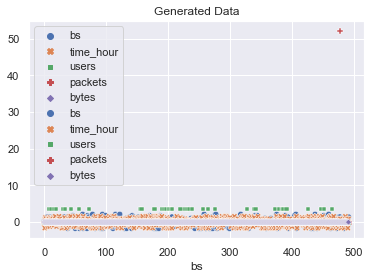

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt

real = synthesizer.get_data_batch(train=df, batch_size=test_size, seed=seed)
real_samples = pd.DataFrame(real, columns=data_cols)

z = np.random.normal(size=(test_size, noise_dim))
generated_z = synthesizer.generator.predict(z)
ax = plt.subplot()
gen_samples = pd.DataFrame(generated_z, columns=data_cols)
gen_samples.to_csv('Generated_sample.csv')
sns.scatterplot(data=gen_samples )
sns.scatterplot(data=real_samples )
plt.title("Generated Data")
plt.xlabel(data_cols[0])
#ax.set_xlim(xlims), ax.set_ylim(ylims)
gen_samples


In [29]:
# Part 1. section 3.a
# Collect generated samples with realatively high and low probability in the discriminator
high_acc = np.zeros(100)
high_val = 100*[None]

low_acc = np.ones(100)
low_val = 100*[None]

for i in range(100):
    z = np.random.normal(size=(test_size, noise_dim))
    generated_z = synthesizer.generator.predict(z)

    y_pred = synthesizer.discriminator.predict(generated_z)
    # print(y_pred.min(), y_pred.max(), y_pred.mean())
    # break
    for i, val in enumerate(y_pred):
        if val > high_acc.min():
            high_acc[np.argmin(high_acc)] = val
            high_val[np.argmin(high_acc)] = generated_z[i]

        elif val < low_acc.max():
            low_acc[np.argmax(low_acc)] = val
            low_val[np.argmax(low_acc)] = generated_z[i]


16/16 [==============================] - 0s 1ms/step


* high prob acc on discriminator -> discriminator succeed more than generator -> not fooled discriminator -> more far than real data

* low prob acc on discriminator -> generator succeed more than discriminator -> fooled the discriminator -> closer to real data

Euclidian Distance of generated data that fooled discriminator is closer to the real data comparing to samples that didn't fool

In [30]:
# Part 1. section 3.a - cont.
# Euclidian distance and cosine similarity
mean_real_data = df.mean(axis=0)

mat = np.asarray(high_val)
mean_high_prob_fake = mat.mean(axis=0)
 
mat = np.asarray(low_val)
mean_low_prob_fake = mat.mean(axis=0)

print("Euclidian Distance of generated data that didn't fool the discrimminator: ",np.linalg.norm(mean_high_prob_fake - mean_real_data))
print("Euclidian Distance of generated data that fool the discrimminator: ", np.linalg.norm(mean_low_prob_fake - mean_real_data))

from scipy import spatial
# higher is better
print("\nCosine similarity of generated data that didn't fool the discrimminator: ", 1 - spatial.distance.cosine(mean_high_prob_fake, mean_real_data))
print("Cosine similarity of generated data that fool the discrimminator: ", 1 - spatial.distance.cosine(mean_low_prob_fake, mean_real_data))

Euclidian Distance of generated data that didn't fool the discrimminator:  0.8101318975853863
Euclidian Distance of generated data that fool the discrimminator:  1.098152099362169

Cosine similarity of generated data that didn't fool the discrimminator:  0.12298856140948689
Cosine similarity of generated data that fool the discrimminator:  0.7567090576882207


Text(0.5, 1.0, 'Examples that fooled Disciminator PCA')

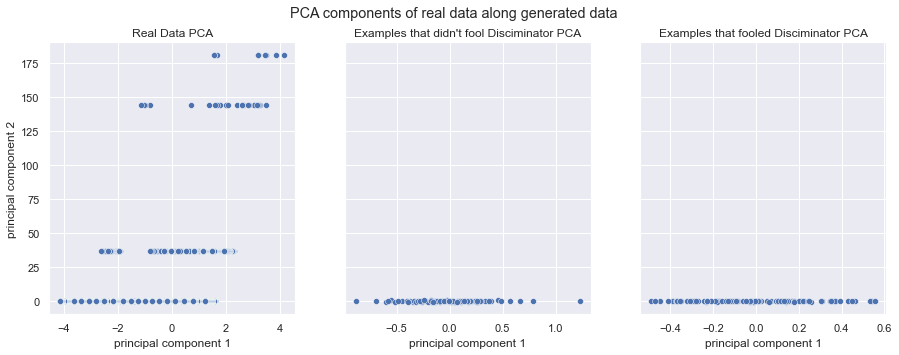

In [31]:
# Part 1. section 3.a - visualization: PCA
from sklearn.decomposition import PCA
import seaborn as sns
from matplotlib import pyplot as plt
sns.set()

# Convert generated samples to ndarray
high_val = np.asarray(high_val)
low_val = np.asarray(low_val)

# decompose to PCA and show
def get_pca_df(df):
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(df)
    principalDf = pd.DataFrame(data = principalComponents
                , columns = ['principal component 1', 'principal component 2'])
    return principalDf

real_pca = get_pca_df(df)
high_val_pca = get_pca_df(high_val)
low_val_pca = get_pca_df(low_val)

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
fig.suptitle('PCA components of real data along generated data')

sns.scatterplot(data=real_pca, x="principal component 1", y="principal component 2", ax=axes[0])
axes[0].set_title('Real Data PCA')
sns.scatterplot(data=high_val_pca, x="principal component 1", y="principal component 2", ax=axes[1])
axes[1].set_title('Examples that didn\'t fool Disciminator PCA')
sns.scatterplot(data=low_val_pca, x="principal component 1", y="principal component 2", ax=axes[2])
axes[2].set_title('Examples that fooled Disciminator PCA')


In [ ]:
# Part 1. section 3.b
batch_size = 100
z = np.random.normal(size=(batch_size, noise_dim))
generated_z = synthesizer.generator.predict(z)

y_pred = synthesizer.discriminator.predict(generated_z)
print(y_pred.min(), y_pred.max(), y_pred.mean())
# break
counter = 0
for i, val in enumerate(y_pred):
    if val > 0.5:
        counter+=1
print(f"{counter} samples out of {batch_size} were able to pass as real samples")